# goes-orthorectify

Orthorectify and clip a GOES ABI image using the mapping created by goes-make-orth-map

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#import warnings
#warnings.filterwarnings('ignore')

#### Open a GOES-16 image

In [2]:
image_path = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\goes16\2017\03\1\ABI-L1b-RadC\00\C14\OR_ABI-L1b-RadC-M3C14_G16_s20170600002497_e20170600005270_c20170600005307.nc'

In [3]:
image = xr.open_dataset(image_path)
image.x

<xarray.DataArray 'x' (x: 2500)>
array([-0.075012, -0.074956, -0.0749  , ...,  0.06482 ,  0.064876,  0.064932],
      dtype=float32)
Coordinates:
    t        datetime64[ns] ...
  * x        (x) float32 -0.075012 -0.074956 -0.0749 ... 0.064876005 0.064932
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

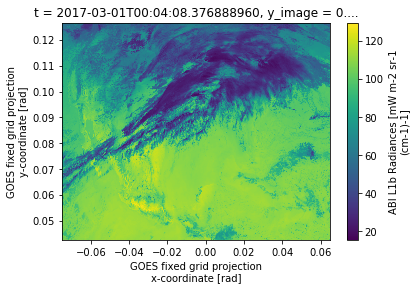

In [4]:
image.Rad.plot()

#### Open the ortho mapping:

In [5]:
tuol_test = xr.open_dataset('test_map_tuol.nc')
print(tuol_test)

<xarray.Dataset>
Dimensions:              (x: 1995, y: 1501)
Coordinates:
    longitude            (x) float64 ...
    latitude             (y) float64 ...
    dem_px_angle_x       (y, x) float64 ...
    dem_px_angle_y       (y, x) float64 ...
Dimensions without coordinates: x, y
Data variables:
    abi_500m_px_angle_x  (y, x) float64 ...
    abi_500m_px_angle_y  (y, x) float64 ...
    abi_1km_px_angle_x   (y, x) float64 ...
    abi_1km_px_angle_y   (y, x) float64 ...
    abi_2km_px_angle_x   (y, x) float64 ...
    abi_2km_px_angle_y   (y, x) float64 ...
    elevation            (y, x) float64 ...
Attributes:
    longitude_of_projection_origin:                 -89.5
    semi_major_axis:                                6378137
    semi_minor_axis:                                6356752.31414
    perspective_point_height+semi_major_axis:       42164160
    grs80_eccentricity:                             0.0818191910435
    longitude_of_projection_origin_info:            longitude of geost

#### Map and clip the image to the pixel map

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |


(1501, 1995)


C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\core\indexes\base.py:2825: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


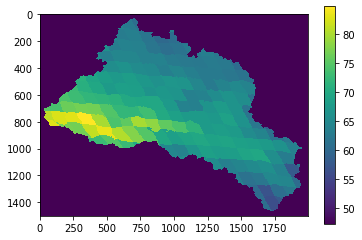

In [68]:
# this finds the nearest x and y in the GOES ABI image for each DEM grid cell and returns the Rad values
# in the same shape and size as the original DEM
s = image.sel(x=tuol_test.dem_px_angle_x, y=tuol_test.dem_px_angle_y, method='nearest').Rad.values
print(s.shape)
plt.imshow(s)
plt.colorbar()